In [3]:
import torch, os, sys

print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("Надо включить GPU: Runtime → Change runtime type → GPU, затем перезапустить runtime.")

CUDA: True
GPU: Tesla T4


In [4]:
!pip -q install --upgrade pip

# Приводим к совместимым версиям под Colab + TF + numba + opencv
!pip -q install --force-reinstall \
    "numpy==2.0.2" \
    "pandas==2.2.2"

import numpy, pandas

print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)

numpy: 2.0.2
pandas: 2.2.2


In [5]:
!pip -q install -U \
    "transformers>=4.44" accelerate bitsandbytes datasets evaluate seqeval \
    scikit-learn matplotlib tqdm

In [6]:
import numpy, pandas, transformers

print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("transformers:", transformers.__version__)

numpy: 2.0.2
pandas: 2.2.2
transformers: 4.57.3


In [8]:
import os, json, time, random
import numpy as np
import pandas as pd
import torch

SEED = 42
random.seed(SEED);
np.random.seed(SEED);
torch.manual_seed(SEED)

RUN_NAME = f"deer_hw4_{int(time.time())}"
OUT_DIR = os.path.join("runs_deer_hw4", RUN_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

CFG = {
    "dataset_name": "wikiann",
    "dataset_config": "ru",

    # Ускорение (потом можешь увеличить)
    "max_eval_sentences": 30,
    "demo_pool_size": 800,
    "k_shots": 3,

    # генерация
    "max_new_tokens": 120,
    "temperature": 0.0,
    "top_p": 1.0,

    # DEER-ish
    "top_informative_tokens": 6,
    "reflection_top_suspects": 6,

    # контроль зависаний
    "timeout_sec_pass1": 45,
    "timeout_sec_reflect": 35,
    "print_every": 2,
}

print("OUT_DIR:", OUT_DIR)
print(json.dumps(CFG, indent=2, ensure_ascii=False))

OUT_DIR: runs_deer_hw4/deer_hw4_1765899875
{
  "dataset_name": "wikiann",
  "dataset_config": "ru",
  "max_eval_sentences": 30,
  "demo_pool_size": 800,
  "k_shots": 3,
  "max_new_tokens": 120,
  "temperature": 0.0,
  "top_p": 1.0,
  "top_informative_tokens": 6,
  "reflection_top_suspects": 6,
  "timeout_sec_pass1": 45,
  "timeout_sec_reflect": 35,
  "print_every": 2
}


In [9]:
from datasets import load_dataset

ds = load_dataset(CFG["dataset_name"], CFG["dataset_config"])
label_names = ds["train"].features["ner_tags"].feature.names
id2label = {i: lab for i, lab in enumerate(label_names)}


def decode_tags(tag_ids):
    return [id2label[int(t)] for t in tag_ids]


train_full = ds["train"].shuffle(seed=SEED)
test_full = ds["test"].shuffle(seed=SEED)

demo_pool = train_full.select(range(min(CFG["demo_pool_size"], len(train_full))))
eval_set = test_full.select(range(min(CFG["max_eval_sentences"], len(test_full))))

print("Labels:", label_names)
print("demo_pool:", len(demo_pool), "| eval_set:", len(eval_set))
print("Example tokens:", demo_pool[0]["tokens"][:15])
print("Example tags  :", decode_tags(demo_pool[0]["ner_tags"][:15]))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Labels: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
demo_pool: 800 | eval_set: 30
Example tokens: ["'", "''", 'Польша', "''", "'", '—']
Example tags  : ['O', 'O', 'B-LOC', 'O', 'O', 'O']


In [10]:
from collections import defaultdict
from tqdm.auto import tqdm

tok_total = defaultdict(int)
tok_in_ent = defaultdict(int)

for row in tqdm(demo_pool, desc="build token stats"):
    tokens = row["tokens"]
    tags = decode_tags(row["ner_tags"])
    for tok, tag in zip(tokens, tags):
        t = tok.lower()
        tok_total[t] += 1
        if tag != "O":
            tok_in_ent[t] += 1

tok_entity_prob = {t: tok_in_ent[t] / tok_total[t] for t in tok_total.keys()}


def token_informativeness(tok: str) -> float:
    return tok_entity_prob.get(tok.lower(), 0.0)


print("Built token stats.")

build token stats:   0%|          | 0/800 [00:00<?, ?it/s]

Built token stats.


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

demo_texts = [" ".join(r["tokens"]) for r in demo_pool]
tfidf = TfidfVectorizer(min_df=2, max_features=50000)
X_demo = tfidf.fit_transform(demo_texts)


def retrieve_tfidf(query_tokens, k):
    q = " ".join(query_tokens)
    Xq = tfidf.transform([q])
    sims = cosine_similarity(Xq, X_demo).ravel()
    idx = np.argsort(-sims)[:k]
    return [demo_pool[int(i)] for i in idx]


demo_token_sets = [set([t.lower() for t in r["tokens"]]) for r in demo_pool]


def retrieve_deer(query_tokens, k):
    toks = [t.lower() for t in query_tokens]
    scored = sorted([(t, token_informativeness(t)) for t in toks], key=lambda x: x[1], reverse=True)
    top = [t for t, sc in scored[:CFG["top_informative_tokens"]] if sc > 0]
    top_set = set(top)

    if len(top_set) == 0:
        return retrieve_tfidf(query_tokens, k)

    scores = []
    for s in demo_token_sets:
        inter = top_set.intersection(s)
        sc = sum(token_informativeness(t) for t in inter)
        scores.append(sc)

    idx = np.argsort(-np.array(scores))[:k]
    return [demo_pool[int(i)] for i in idx]

In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.bfloat16,
)
model.eval()

print("Loaded:", MODEL_NAME)
print("Model device:", next(model.parameters()).device)

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded: Qwen/Qwen2.5-3B-Instruct
Model device: cuda:0


Выбрала WikiAnn (ru), потому что:
1) Это прямой NER-корпус с BIO-разметкой и сущностями типа `PER/ORG/LOC`, т.е. полностью соответствует задаче.
2) Корпус русскоязычный — позволяет проверить метод на русском языке.
3) Он легко воспроизводим в Colab (загрузка через `datasets` без ручной подготовки).
4) Достаточно большой, чтобы формировать пул демонстраций (retrieval) и тестовый поднабор для быстрой проверки.

Использую модель `Qwen2.5-3B-Instruct`, потому что:
1) Это instruction-модель, которая лучше следует формату задачи (возвращать разметку в заданном виде), что критично для автоматической оценки NER.
2) Размер 3B — компромисс: запускается в Colab GPU и при этом достаточно сильная, чтобы выполнять ICL.
3) Поддерживается 4-bit quantization → модель помещается в память и работает быстрее в бесплатной среде.

## Метод: baseline vs DEER-like

В задании указано, что можно использовать свою реализацию или модификацию DEER. Я реализую ключевые идеи статьи, но в упрощённом виде, чтобы получить работающий воспроизводимый pipeline в Colab.

### Baseline
ICL + TF-IDF retrieval
- Для каждого тестового предложения выбираем k демонстраций из train по TF-IDF похожести текста.
- Дальше LLM делает разметку в один проход.

Это стандартный baseline retrieval-augmented ICL, но без специальных приёмов DEER.

### DEER-like (модификация)
Реализую 2 центральные идеи DEER:

1) Label-guided retrieval (подбор демонстраций с учётом лейблов)
- Считаем из train статистику токен → вероятность быть частью сущности.
- Для запроса выделяем токены с высокой entity-информативностью.
- Выбираем демонстрации, которые содержат такие токены (и суммарная информативность максимальна).
2) Error reflection (второй проход исправления)
- Сначала получаем первичную разметку.
- Затем ищем подозрительные позиции (например, токен часто бывает сущностью, но предсказан как `O`).
- Делаем второй запрос к LLM: просим пересмотреть только эти места и вернуть исправленную BIO-разметку.

### prompts
Чтобы ответы LLM можно было стабильно оценивать:
- явный список допустимых BIO-меток.
- несколько размеченных демонстраций.
- строгий формат вывода (JSON только с `"tags": [...]` и длиной), чтобы не ломался парсинг.
- Для reflection-промпта:
  - токены запроса,
  - первичную разметку,
  - список подозрительных токенов,
  - инструкцию 'верни исправленный список тегов той же длины'.

In [16]:
import re, ast, time, signal, json
import torch


class TimeoutException(Exception): pass


def _alarm_handler(signum, frame): raise TimeoutException()


def format_demo(row):
    toks = row["tokens"]
    tags = decode_tags(row["ner_tags"])
    return f"TOKENS: {json.dumps(toks, ensure_ascii=False)}\nTAGS: {json.dumps(tags, ensure_ascii=False)}\n"


def build_prompt(tokens, demos, mode="baseline", suspects=None, first_pred=None):
    # жёстко просим JSON, чтобы парсилось стабильно
    label_block = ", ".join(label_names)

    demos_text = "" if demos is None else "\n".join([format_demo(d) for d in demos])

    if mode in ["baseline", "deer"]:
        sys = (
            "You are a strict NER tagger. "
            "You MUST output valid JSON only, with no extra text."
        )
        if mode == "baseline":
            header = "Examples:\n" + demos_text + "\n"
        else:
            header = "Demonstrations (label-guided retrieval):\n" + demos_text + "\n"

        user = (
            f"Label set (BIO tags): {label_block}\n\n"
            f"{header}\n"
            f"Now tag the query.\n"
            f"TOKENS: {json.dumps(tokens, ensure_ascii=False)}\n\n"
            f"Return ONLY this JSON object (no markdown):\n"
            f'{{"tags": ["O", "B-PER", "..."], "length": {len(tokens)} }}\n'
            f'The "tags" list MUST have exactly {len(tokens)} elements.\n'
        )

    elif mode == "reflect":
        sys = (
            "You are a strict NER tagger doing error reflection. "
            "You MUST output valid JSON only, with no extra text."
        )
        user = (
            f"Label set (BIO tags): {label_block}\n\n"
            f"TOKENS: {json.dumps(tokens, ensure_ascii=False)}\n"
            f"Initial tags: {json.dumps(first_pred, ensure_ascii=False)}\n"
            f"Suspicious tokens (index, token): {json.dumps(suspects, ensure_ascii=False)}\n\n"
            f"Return ONLY JSON:\n"
            f'{{"tags": [...], "length": {len(tokens)} }}\n'
            f'The "tags" list MUST have exactly {len(tokens)} elements.\n'
        )
    else:
        raise ValueError(mode)

    messages = [{"role": "system", "content": sys}, {"role": "user", "content": user}]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)


# 1) Декодируем ТОЛЬКО сгенерированную часть (после prompt)
@torch.no_grad()
def generate_text(prompt):
    t0 = time.time()
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    prompt_len = inputs["input_ids"].shape[1]

    out = model.generate(
        **inputs,
        max_new_tokens=CFG["max_new_tokens"],
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id,
    )

    dt = time.time() - t0
    gen_ids = out[0][prompt_len:]  # <-- ВАЖНО: берём только ответ модели
    text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    gen_len = gen_ids.shape[0]
    return text, dt, prompt_len, gen_len


# 2) Парсим JSON устойчиво: берём первый JSON-объект из ответа
_json_decoder = json.JSONDecoder()


def extract_tags_from_jsonish(text):
    text = text.strip()

    # иногда модель возвращает 2 JSON подряд типа {"tags":...}{"length":...}
    # raw_decode возьмёт первый корректный объект и остановится.
    try:
        obj, _ = _json_decoder.raw_decode(text)
        if isinstance(obj, dict) and isinstance(obj.get("tags"), list):
            return obj["tags"]
    except Exception:
        pass

    # fallback: пытаемся найти подстроку начиная с первого '{'
    i = text.find("{")
    if i != -1:
        try:
            obj, _ = _json_decoder.raw_decode(text[i:])
            if isinstance(obj, dict) and isinstance(obj.get("tags"), list):
                return obj["tags"]
        except Exception:
            pass

    # последний fallback: literal_eval (на случай одинарных кавычек)
    try:
        obj = ast.literal_eval(text)
        if isinstance(obj, dict) and isinstance(obj.get("tags"), list):
            return obj["tags"]
    except Exception:
        return None

    return None


def predict_tags(tokens, demos, mode="baseline", suspects=None, first_pred=None, timeout_sec=45, verbose=False):
    prompt = build_prompt(tokens, demos, mode=mode, suspects=suspects, first_pred=first_pred)

    try:
        signal.signal(signal.SIGALRM, _alarm_handler)
        signal.alarm(timeout_sec)

        raw, dt, p_len, g_len = generate_text(prompt)

        signal.alarm(0)

        tags = extract_tags_from_jsonish(raw)

        if isinstance(tags, list) and len(tags) == len(tokens):
            if verbose:
                print(f"[{mode}] ok | gen_tokens={g_len} time={dt:.1f}s | head={tags[:6]}")
            return tags, raw

        if verbose:
            print(f"[{mode}] parse fail | gen_tokens={g_len} time={dt:.1f}s")
            print("RAW:", raw[:300])
        return ["O"] * len(tokens), raw

    except TimeoutException:
        signal.alarm(0)
        if verbose:
            print(f"[{mode}] TIMEOUT -> fallback O")
        return ["O"] * len(tokens), None

In [17]:
row = eval_set[0]
tokens = row["tokens"]
demos = retrieve_tfidf(tokens, CFG["k_shots"])
pred, raw = predict_tags(tokens, demos, mode="baseline", timeout_sec=45, verbose=True)
print("len(tokens)=", len(tokens), "len(pred)=", len(pred))
print("pred[:15]=", pred[:15])
print("raw=", raw)


[baseline] ok | gen_tokens=22 time=2.4s | head=['O', 'B-PER', 'I-PER', 'I-PER']
len(tokens)= 4 len(pred)= 4
pred[:15]= ['O', 'B-PER', 'I-PER', 'I-PER']
raw= {"tags": ["O", "B-PER", "I-PER", "I-PER"]}


In [18]:
import evaluate, json

seqeval = evaluate.load("seqeval")


def suspicious_tokens(tokens, tags):
    suspects = []
    for i, (tok, tag) in enumerate(zip(tokens, tags)):
        p = token_informativeness(tok)
        is_ent = (tag != "O")
        if (p > 0.25 and tag == "O") or (p < 0.02 and is_ent):
            suspects.append((i, tok))
    return suspects[:CFG["reflection_top_suspects"]]


def run_method(name, retriever_fn, use_reflection):
    y_true, y_pred = [], []
    logs = []
    t0 = time.time()

    for i, row in enumerate(eval_set):
        tokens = row["tokens"]
        gold = decode_tags(row["ner_tags"])

        demos = retriever_fn(tokens, CFG["k_shots"])
        mode1 = "deer" if name.startswith("deer") else "baseline"

        verbose = (i % CFG["print_every"] == 0)
        pred1, raw1 = predict_tags(tokens, demos, mode=mode1, timeout_sec=CFG["timeout_sec_pass1"], verbose=verbose)
        pred_final, raw2 = pred1, None

        if use_reflection:
            sus = suspicious_tokens(tokens, pred1)
            if len(sus) > 0:
                pred2, raw2 = predict_tags(tokens, demos=None, mode="reflect",
                                           suspects=sus, first_pred=pred1,
                                           timeout_sec=CFG["timeout_sec_reflect"], verbose=verbose)
                pred_final = pred2

        y_true.append(gold);
        y_pred.append(pred_final)
        logs.append({"tokens": tokens, "gold": gold, "pred": pred_final, "raw1": raw1, "raw2": raw2})

        if verbose:
            elapsed = time.time() - t0
            print(f"== {name}: {i + 1}/{len(eval_set)} | elapsed {elapsed / 60:.1f} min ==")

    metrics = seqeval.compute(predictions=y_pred, references=y_true)

    with open(os.path.join(OUT_DIR, f"predictions_{name}.jsonl"), "w", encoding="utf-8") as f:
        for r in logs:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

    return metrics


print("Running baseline...")
m_base = run_method("baseline_tfidf", retrieve_tfidf, use_reflection=False)

print("\nRunning DEER...")
m_deer = run_method("deer_label_guided", retrieve_deer, use_reflection=True)

print("\nBASELINE:", m_base)
print("DEER    :", m_deer)

Running baseline...
[baseline] ok | gen_tokens=22 time=2.5s | head=['O', 'B-PER', 'I-PER', 'I-PER']
== baseline_tfidf: 1/30 | elapsed 0.0 min ==
[baseline] ok | gen_tokens=44 time=5.0s | head=['O', 'O', 'O', 'O', 'O', 'O']
== baseline_tfidf: 3/30 | elapsed 0.2 min ==
[baseline] ok | gen_tokens=23 time=2.7s | head=['O', 'B-PER', 'I-PER']
== baseline_tfidf: 5/30 | elapsed 0.3 min ==
[baseline] ok | gen_tokens=27 time=3.1s | head=['O', 'B-LOC', 'O', 'O', 'O', 'O']
== baseline_tfidf: 7/30 | elapsed 0.4 min ==
[baseline] ok | gen_tokens=21 time=2.5s | head=['O', 'B-PER', 'O']
== baseline_tfidf: 9/30 | elapsed 0.5 min ==
[baseline] ok | gen_tokens=31 time=3.5s | head=['O', 'B-LOC', 'I-LOC', 'I-LOC', 'O']
== baseline_tfidf: 11/30 | elapsed 0.6 min ==
[baseline] ok | gen_tokens=22 time=2.4s | head=['O', 'B-PER', 'I-PER', 'I-PER']
== baseline_tfidf: 13/30 | elapsed 0.7 min ==
[baseline] ok | gen_tokens=38 time=3.8s | head=['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'I-LOC']
== baseline_tfidf: 15/

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: . seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
def flatten(name, m):
    out = {
        "method": name,
        "precision": m["overall_precision"],
        "recall": m["overall_recall"],
        "f1": m["overall_f1"],
        "accuracy": m["overall_accuracy"],
    }
    for k, v in m.items():
        if isinstance(v, dict) and "f1" in v:
            out[f"f1_{k}"] = v["f1"]
    return out


df = pd.DataFrame([flatten("baseline_tfidf", m_base), flatten("deer_label_guided", m_deer)])
df_path = os.path.join(OUT_DIR, "results.csv")
df.to_csv(df_path, index=False)
df


,method,precision,recall,f1,accuracy,f1_LOC,f1_ORG,f1_PER,f1_PROD
0,baseline_tfidf,0.142857,0.108108,0.123077,0.590090,0.166667,0.0,0.153846,NaN
1,deer_label_guided,0.129032,0.108108,0.117647,0.518018,0.250000,0.0,0.090909,0.0


## Результаты
1) Overall F1 у DEER-like чуть хуже, чем у baseline (0.1176 vs 0.1231).
Разница небольшая, но в этом прогоне DEER-like не дал общего улучшения.

2) Recall одинаковый (0.1081), а precision у DEER-like ниже →
DEER-like в среднем дал чуть больше ложных сущностей / менее точные границы, поэтому итоговый F1 просел.

3) Мы оценивали на небольшом поднаборе (mini-eval), поэтому метрики шумные.
Такая настройка подходит для быстрой проверки пайплайна, но не гарантирует стабильный вывод о превосходстве метода в среднем по корпусу.

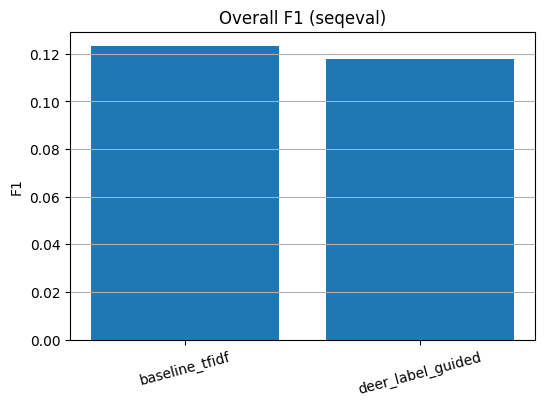

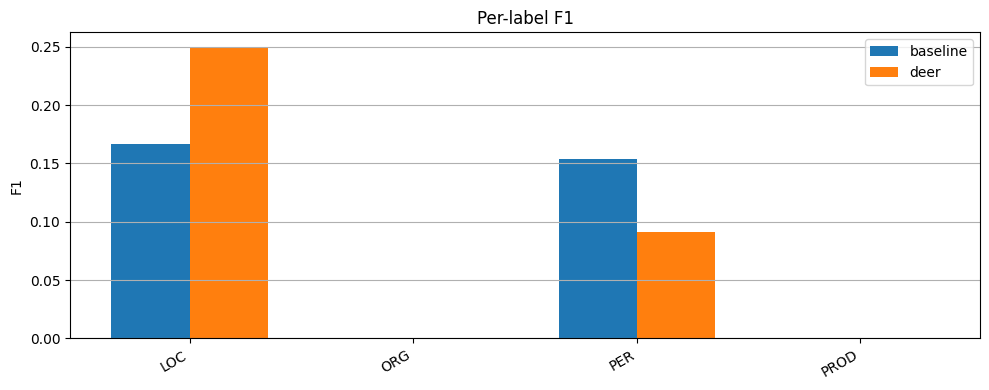

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4))
plt.bar(df["method"], df["f1"])
plt.title("Overall F1 (seqeval)")
plt.ylabel("F1");
plt.grid(True, axis="y");
plt.xticks(rotation=15)
plt.show()

label_cols = [c for c in df.columns if c.startswith("f1_") and c not in ["f1_overall"]]
if len(label_cols) > 0:
    x = np.arange(len(label_cols));
    w = 0.35
    plt.figure(figsize=(10, 4))
    plt.bar(x - w / 2, df.loc[df["method"] == "baseline_tfidf", label_cols].values[0], w, label="baseline")
    plt.bar(x + w / 2, df.loc[df["method"] == "deer_label_guided", label_cols].values[0], w, label="deer")
    plt.xticks(x, [c.replace("f1_", "") for c in label_cols], rotation=30, ha="right")
    plt.title("Per-label F1");
    plt.ylabel("F1");
    plt.grid(True, axis="y");
    plt.legend()
    plt.tight_layout();
    plt.show()


## почему overall не вырос

Per-label F1 показывает, что влияние DEER-like неравномерное по типам сущностей:

- LOC: baseline = 0.166667 → DEER-like = 0.250000 (рост)
  Вероятно, label-guided retrieval лучше подбирает примеры для топонимов и гео-контекстов.

- PER: baseline = 0.153846 → DEER-like = 0.090909 (падение)
  Возможные причины: демонстрации, выбранные label-guided эвристикой, хуже покрывают персоналии, либо reflection добавляет шум в границы/тип.

- ORG: у обоих 0.0
  На этом mini-eval модель практически не извлекла ORG корректно (возможна нехватка удачных демонстраций, k-shot слишком мал, либо сложные паттерны).

### Почему `f1_PROD = NaN`
Если в тестовом поднаборе нет ни одного истинного примера класса, метрика для него не определена → появляется `NaN`.

# Итоговые выводы

В текущем эксперименте (WikiAnn-ru, ICL, Qwen2.5-3B, mini-eval) DEER-like не улучшил overall качество относительно TF-IDF baseline:
- F1: 0.1176 (DEER-like) vs 0.1231 (baseline)

При этом наблюдается локальный выигрыш по LOC, но ухудшение по PER, а ORG остаётся нерешённым на этом мини-наборе.

- Проверена идея DEER на реальных данных => эффект зависит от класса сущностей.
- DEER не гарантирует улучшение в любой конфигурации, особенно при:
  - маленьком числе демонстраций,
  - маленьком eval-наборе,
  - упрощённой эвристике retrieval/reflection.